In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import load_model
from sklearn.externals import joblib

import sys
sys.path.append('/project/dissertation')

# Load custom modules
from utils.config import config as cf
import utils.feature_eng_utils as feature_utils
from utils import ml_models
from utils.text_embedding import FastTextVectorizer
from utils import neural_network_model as nn_model


import warnings
warnings.filterwarnings('ignore')

from sklearn.externals import joblib
lb_encoder_filename = cf.EXPORT_PATH + '/final_model/label_encoder.save'
scaler_filename = cf.EXPORT_PATH + 'final_model/amount_scaler.save'

In [2]:
def load_data(file_name):
    df = pd.read_csv(file_name)
    df['Description'] = df['Description'].fillna('')
    df = feature_utils.preprocess_description(df, True)
    X = df[['Description','Amount_logabs','isExpense', 'isAcctNo','isForeignCurr', 'isOverseas']]
    y = df['label']
    return X, y

X_train, y_train = load_data(cf.DATA_PATH+'/train.csv')
X_test, y_test = load_data(cf.DATA_PATH+'/test.csv')

======= Load Currency :::  /project/dissertation/resources/currency.csv
Total  285  rows
======= Load Cities name :::  /project/dissertation/resources/nz_cities.csv
Total  1040  rows
======= Load Stopword name :::  /project/dissertation/resources/stop_words.csv
Total  10  rows
======= Load Currency :::  /project/dissertation/resources/currency.csv
Total  285  rows
======= Load Cities name :::  /project/dissertation/resources/nz_cities.csv
Total  1040  rows
======= Load Stopword name :::  /project/dissertation/resources/stop_words.csv
Total  10  rows


# Create Text-embeddings for Training/Testing set

In [3]:
fasttext_vectorizer = FastTextVectorizer()

In [4]:
X_train_emb = fasttext_vectorizer.fit_transform(X_train['Description'])
X_test_emb = fasttext_vectorizer.transform(X_test['Description'])

np.save(cf.EXPORT_PATH + 'text_embeddings/train_desc', X_train_emb)
np.save(cf.EXPORT_PATH + 'text_embeddings/test_desc', X_test_emb)
print('Text Embedding  exported!')

Text Embedding  exported!


# Re-trained the model with all training data

## Load Text-embeddings

In [3]:
X_train_emb = pd.DataFrame(np.load(cf.EXPORT_PATH+'/text_embeddings/train_desc.npy'))

### Create the Final Training dataframe and Export Amount scaler for later used

In [6]:
scaler = StandardScaler()
X_train['Amount_t'] = scaler.fit_transform(X_train['Amount_logabs'].values.reshape(-1,1))
X_train_final = pd.concat([X_train_emb,  X_train[['isExpense', 'isAcctNo', 'isOverseas']]], axis=1)

joblib.dump(scaler, scaler_filename) 

['/project/dissertation/output/final_model/amount_scaler.save']

### Transform labels into matrix and save the Label Encoder

In [8]:
lb_make = LabelEncoder()
y_train_final = lb_make.fit_transform(y_train)
y_train_final= to_categorical(np.asarray(y_train_final))

joblib.dump(lb_make, lb_encoder_filename) 

['/project/dissertation/output//final_model/label_encoder.save']

### Initialize and fit the Neural Network model

In [40]:
time_callback = nn_model.TimeHistory()
model = nn_model.initialize_nn_model(X_train_final.shape[1], y_train_final.shape[1])
model.summary()
history = model.fit(X_train_final, y_train_final, epochs=40, verbose=2, validation_split=0.2, batch_size=10, callbacks=[time_callback])

In [49]:
np.sum(time_callback.times)

67.51880383491516

### Save Model

In [22]:
model.save(cf.EXPORT_PATH + '/final_model/nn_model.h5')

# Predict unseen data with the final model

## Load Model for New Prediction

In [4]:
model = load_model(cf.EXPORT_PATH + '/final_model/nn_model.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               77824     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 56)                14392     
Total params: 92,216
Trainable params: 92,216
Non-trainable params: 0
_________________________________________________________________


## Load Testing data

In [5]:
X_test_emb = pd.DataFrame(np.load(cf.EXPORT_PATH+'/text_embeddings/test_desc.npy'))

In [6]:
scaler = joblib.load(scaler_filename) 
X_test['Amount_t'] = scaler.transform(X_test['Amount_logabs'].values.reshape(-1,1))
X_test_final = pd.concat([X_test_emb,  X_test[['isExpense', 'isAcctNo', 'isOverseas']]], axis=1)

In [7]:
lb_make = joblib.load(lb_encoder_filename) 
y_test_final = lb_make.transform(y_test)
y_test_final= to_categorical(np.asarray(y_test_final))
y_test_final.shape

(3231, 56)

### Evaluation result

In [8]:
y_test_pred = model.predict(X_test_final)
y_pred_decode = pd.DataFrame(y_test_pred).idxmax(axis=1)
y_pred_decode = lb_make.inverse_transform(y_pred_decode)
class_report= pd.DataFrame(classification_report(y_test, y_pred_decode, output_dict=True)).T
class_report.to_csv(cf.EXPORT_PATH  + 'final_model/classification_report.csv')
class_report

,f1-score,precision,recall,support
Expenses::Business Phone::Mobile Phone Bill,1.000000,1.000000,1.000000,36.00000
Expenses::Business Vehicle::Fuel,0.860558,0.812030,0.915254,118.00000
Expenses::Business Vehicle::Maintenance & Tyres,0.818182,0.692308,1.000000,9.00000
Expenses::Business Vehicle::Parking & Tolls,0.962963,0.928571,1.000000,78.00000
Expenses::Business Vehicle::Registration & Wof,0.400000,1.000000,0.250000,4.00000
Expenses::Charities & Donations::Charities & Donations,0.600000,0.750000,0.500000,6.00000
Expenses::Commercial Office::Office Rent,0.888889,1.000000,0.800000,5.00000
Expenses::General Business::Advertising/Marketing,1.000000,1.000000,1.000000,1.00000
Expenses::General Business::Bank Fees,0.987342,0.991525,0.983193,119.00000
Expenses::General Business::Clothing & Apparel,0.778947,0.770833,0.787234,47.00000


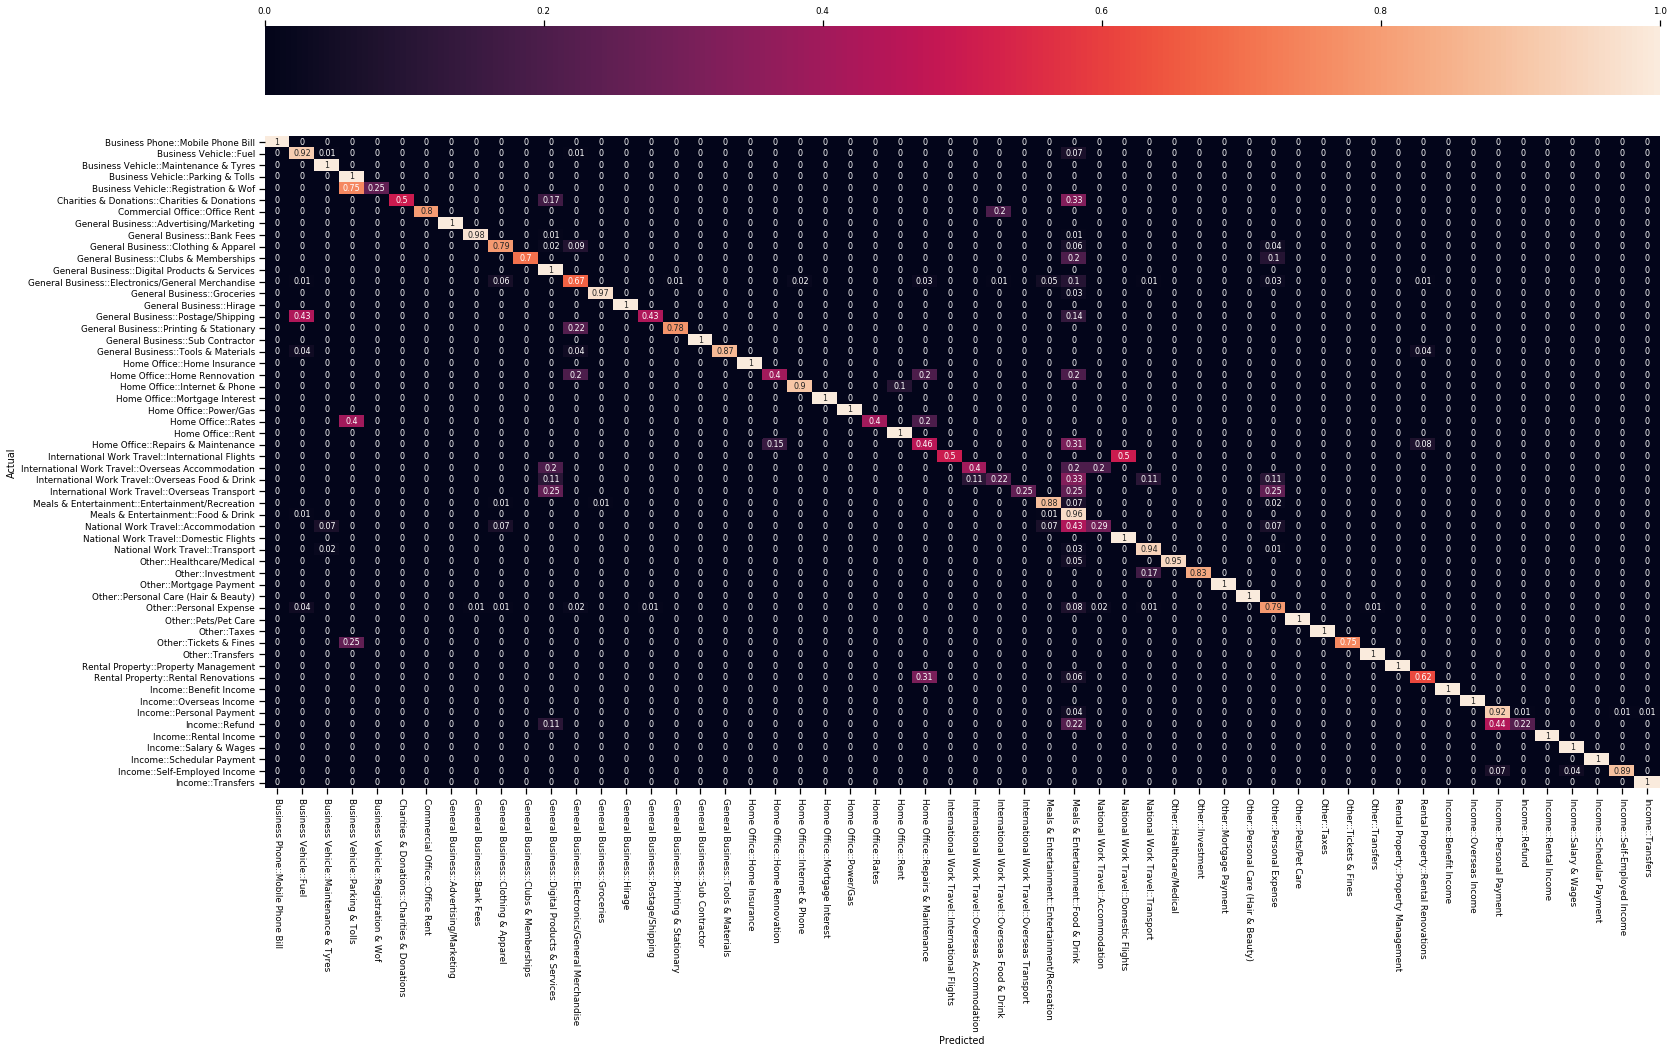

In [9]:
ml_models.show_confusion_matrix(y_test, y_pred_decode, True, figsize=(25,15), rot_x_label=270)

In [10]:
class_report_df = class_report.reset_index()
class_report_df['Type'] = class_report_df['index'].str.split('::').str[0]
class_report_df['Main Category'] = class_report_df['index'].str.split('::').str[1]
class_report_df['Category'] = class_report_df['index'].str.split('::').str[2]
main_class_report = class_report_df.groupby(['Type', 'Main Category']).mean()

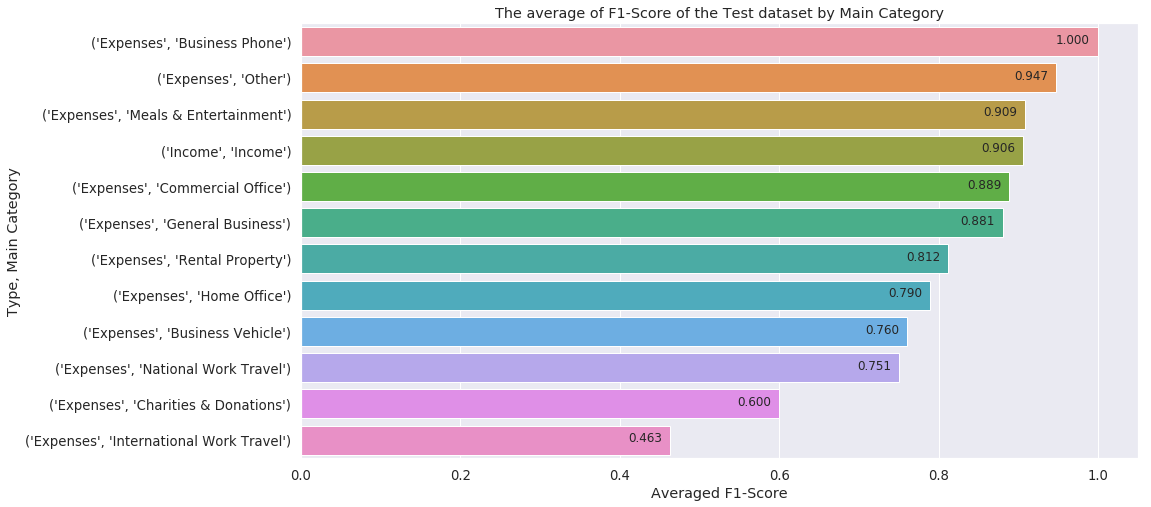

In [11]:
def plot_summarize_main_category(column, main_class_report):
    main_class_report = main_class_report.sort_values(column, ascending=False)
    plt.figure(figsize=(15, 8))
    sns.set_context('notebook', font_scale=1.2)
    sns.set_style('darkgrid')
    fig = sns.barplot(y=main_class_report.index, x=column , data=main_class_report, orient='h')
    fig.set(ylabel='Type, Main Category', xlabel='Averaged F1-Score')
    fig.set(title= 'The average of ' + column.title() + ' of the Test dataset by Main Category')
    for p in fig.patches:
        fig.annotate(format(p.get_width(), '.3f'), (p.get_width() -0.01, p.get_y() + p.get_height()/1.3 ), 
                 ha = 'right', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize=12)
    
plot_summarize_main_category('f1-score', main_class_report)

In [34]:
output = pd.read_csv(cf.DATA_PATH + '/test.csv')
output['predict'] = y_pred_decode
output['isCorrect'] = output['predict'] == output['label'] 
output.to_csv(cf.EXPORT_PATH + '/final_model/output.csv')